In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

$$ V = WH$$

In [2]:
def update_H(W, H, V):
    numerator = W.T.dot(V)
    denominator = W.T.dot(W).dot(H) + 1e-10
    H = H*(numerator / denominator)
    return H

def update_W(W, H, V):
    numerator = V.dot(H.T)
    denominator = W.dot(H).dot(H.T) + 1e-10
    W = W*(numerator / denominator)
    return W

In [204]:
def do_nnmf(V, rank=10, iter=100):
    
    # Initialize 
    n, m = V.shape
    
    W = np.abs(np.random.randn(1, n, rank))[0]
    H = np.abs(np.random.randn(1, rank, m))[0]
    
    loss = []
    for i in range(iter):
        H = update_H(W, H, V)
        W = update_W(W, H, V)
        
        loss.append(sum((V - W.dot(H)).flatten()**2))

    return H, W, loss

In [295]:
img = plt.imread("./images/small.jpg")
V = img[:, :, 1] # only use one ccolor channel

In [296]:
H, W, loss = do_nnmf(V, rank=20, iter=300)

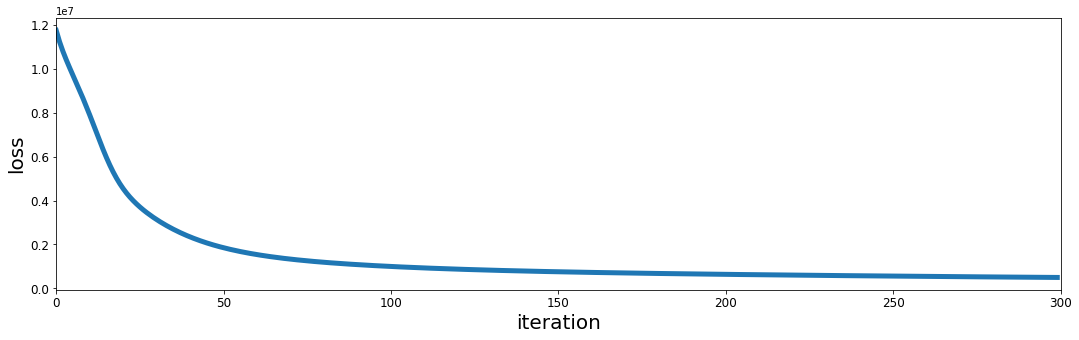

In [303]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(loss, lw=5)
ax.tick_params(labelsize=12)
ax.set_xlim(0, 300)
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('loss', fontsize=20)

plt.show()

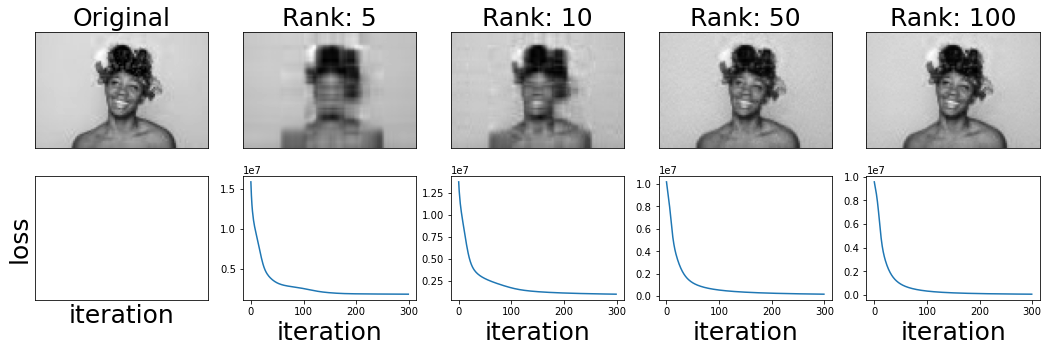

In [225]:
ranks_to_test = [5, 10, 50, 100]

n_plots = len(ranks_to_test) + 1
fig, ax = plt.subplots(2, n_plots, figsize=[18, 5])

# Plot original image as reference
ax[0][0].imshow(V, cmap='gray')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title('Original', fontsize=25)

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_xlabel('iteration', fontsize=25)
ax[1][0].set_ylabel('loss', fontsize=25)

data_points_original = V.shape[0] * V.shape[1]

data_points = []

n = 1
for i in ranks_to_test:
    
    H, W, loss = do_nnmf(V, rank=i, iter=300)
    V_rec = W.dot(H)

    data_points.append((H.shape[0] * H.shape[1]) + (W.shape[0] * W.shape[1]))
    
    ax[0][n].imshow(V_rec, cmap='gray')
    ax[0][n].set_xticks([])
    ax[0][n].set_yticks([])
    ax[0][n].set_title('Rank: {}'.format(i), fontsize=25)
    
    ax[1][n].plot(loss)
    ax[1][n].set_xlabel('iteration', fontsize=25)

    n += 1
    
plt.show()

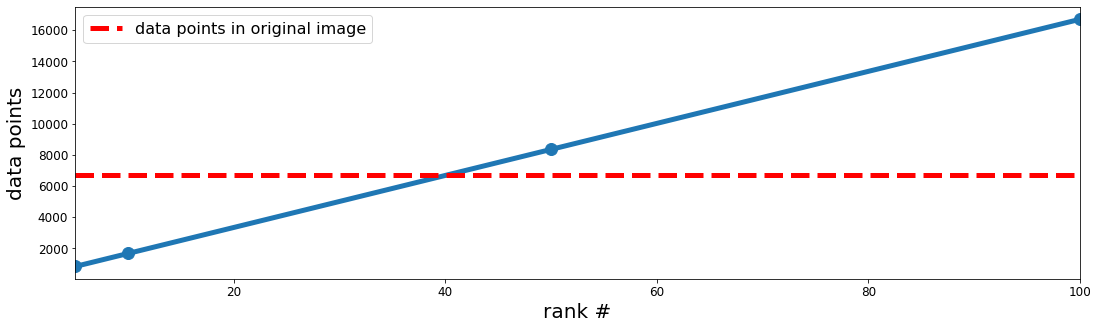

In [310]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(ranks_to_test, data_points, marker='o', lw=5, markersize=12)
ax.plot((ranks_to_test[0], ranks_to_test[-1]), 
        (data_points_original, data_points_original), 
        'r--', lw=5,
        label='data points in original image')

ax.tick_params(labelsize=12)
ax.set_xlim(ranks_to_test[0], ranks_to_test[-1])
ax.set_xlabel('rank #', fontsize=20)
ax.set_ylabel('data points', fontsize=20)
ax.legend(fontsize=16)

plt.show()

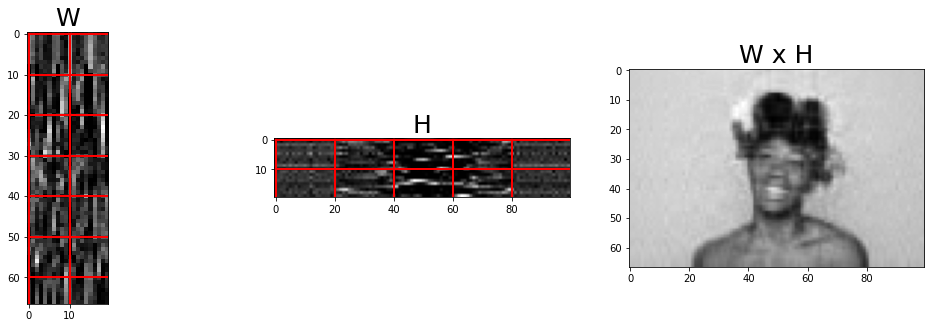

In [164]:
H, W, _ = do_nnmf(V, rank=20, iter=300)
V_rec = W.dot(H)

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

ax[0].imshow(W, cmap='gray')
ax[0].grid(color='r', linestyle='-', linewidth=2)
ax[0].set_title('W', fontsize=25)

ax[1].imshow(H, cmap='gray')
ax[1].grid(color='r', linestyle='-', linewidth=2)
ax[1].set_title('H', fontsize=25)

ax[2].imshow(V_rec, cmap='gray')
ax[2].set_title('W x H', fontsize=25)

plt.show()

In [144]:
print(W.shape[0] * W.shape[1] + H.shape[0] * H.shape[1])
print(V.shape[0] * V.shape[1])

3340
6700


Dataset: https://www.kaggle.com/joseguzman/waveforms

In [243]:
data = pd.read_csv('./data/waveforms.csv')

label = data.iloc[:, 0]
organoid = data.iloc[:, -1]
data = data.iloc[:, 1:-1].to_numpy()
data = data.T + np.abs(np.min(data))

Notebook: https://www.kaggle.com/joseguzman/spike-classification-based-on-waveforms

Related: https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316

In [318]:
n_rank = 3
H, W, loss = do_nnmf(data, rank=n_rank, iter=1000)

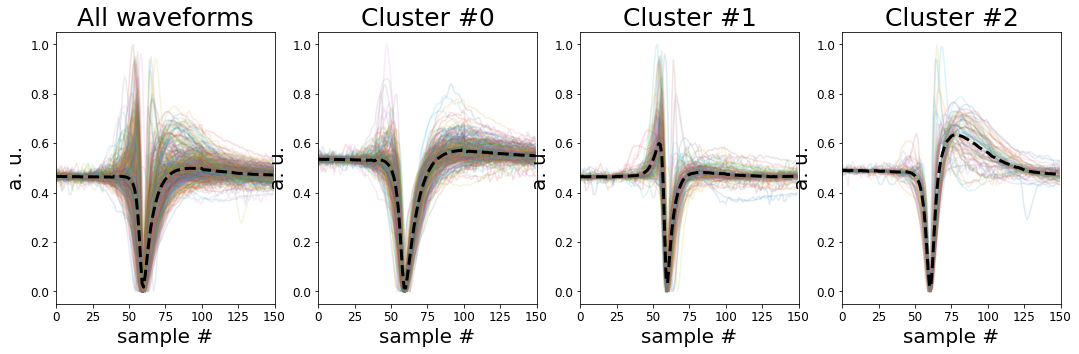

In [319]:
cluster_id = []
for x in range(H.shape[1]):
    cluster_id.append(np.where(np.max(H[:, x]) == H[:, x])[0][0])
    
fig, ax = plt.subplots(1, n_rank + 1, figsize=[18, 5])

all_waveforms = data / np.max(data)
mean_all_waveforms = np.mean(all_waveforms, axis=1)

ax[0].plot(all_waveforms, alpha=0.15)
ax[0].plot(mean_all_waveforms, color='black', linewidth=3, linestyle='dashed')
ax[0].set_title('All waveforms', fontsize=25)
ax[0].set_xlim(0, data.shape[0])
ax[0].set_xlabel('sample #', fontsize=20)
ax[0].set_ylabel('a. u.', fontsize=20)  
ax[0].tick_params(labelsize=12)


for cluster in range(n_rank):
    cluster_index = np.where([x == cluster for x in cluster_id])

    waveforms = data.T[cluster_index].T
    waveforms = waveforms / np.max(waveforms)
    mean_waveform = np.mean(waveforms, axis=1)

    ax[cluster + 1].plot(waveforms, alpha=0.15)
    ax[cluster + 1].plot(mean_waveform, color='black', linewidth=3, linestyle='dashed')
    ax[cluster + 1].set_title('Cluster #{}'.format(cluster), fontsize=25)
    ax[cluster + 1].set_xlim(0, waveforms.shape[0])
    ax[cluster + 1].set_xlabel('sample #', fontsize=20)
    ax[cluster + 1].set_ylabel('a. u.', fontsize=20)    
    ax[cluster + 1].tick_params(labelsize=12)
    
plt.show()